## Información no Estructurada
### Máster Universitario en Ciencia de Datos
# Práctica 3.4 &ndash; Recomendación: factorización de matrices y deep learning

### Autores: 
    - Marlon Rodríguez Flor
    - Alejandra Franco Solorio

Esta práctica tiene por objetivo comprender el diseño de métodos de filtrado colaborativo mediante deep learning como transición desde un modelo bilineal típico de factorización de matrices hacia modelos neuronales de complejidad arbitraria.

El trabajo a realizar se secuencia en los siguiented pasos:
1. Filtrado colaborativo basado en factorización de matrices en NumPy.
2. Repetición del mismo método pero visto como modelo neuronal en TensorFlow o PyTorch (a elegir).
3. Ampliación del modelo introduciendo capas ocultas y/u otras variaciones.

Como punto de partida se plantea en cada caso la formulación de la factorización de matrices más sencilla posible.

Se proporciona gran parte del código; los dos primeros ejercicios consistirán en completar un esqueleto de código, y el tercero queda abierto a la dirección que el estudiante opte por seguir.

## 1.&nbsp; Procesamiento de datos

Se facilita una clase Ratings que se ocupa de las siguientes operaciones:
1. Lectura de datos de rating de un fichero.
2. Preparación de datos en forma de matriz (sin preocuparnos del gasto de RAM: podrían usarse implementaciones sparse matrix para un uso más frugal de RAM y soportar conjuntos de datos más grandes).
3. Binarización de los ratings.
4. Partición de datos en entrenamiento y test.
5. Duplicación redundante de los datos: matriz vs. data frame de ratings de entrenamiento, acorde con diferentes requisitos para diferentes frameworks de implementación (NumPy vs. TensorFlow / PyTorch).

Se hace una implementación simplificada y directa orientada a obtener lo suficiente para los ejercicios de esta práctica, sin buscar más generalidad. Por ejemplo, todas las operaciones (incluida la partición entrenamiento/test) se realizan en el constructor y no se implementan más funciones en la clase que las estrictamente necesarias para los ejercicios y pruebas. Igualmente decidimos trabajar con ratings binarizados.

Se proporcionan una líneas al final de la celda para ilustrar cómo quedan almacenados datos en diferentes subconjuntos y estructuras.

El conjunto de datos `ratings.dat` está disponible en https://grouplens.org/datasets/movielens/1m.

In [8]:
import pandas as pd
import numpy as np

# We cast rating data as 1 for ratings >= threshold (4 by default), and zero for lower vaues or missing ratings.
class Ratings:
    def __init__(self, file, sep=',', split_ratio=.8, threshold=4):
        df = pd.read_csv(file, names=['u', 'i', 'r', 't'], sep=sep, engine='python')
        # Restructure the ratings data into ratings matrix form - and we forget about the original user and item ids: we assign them an incremental int.
        self.ratings_matrix = df.pivot(index='u', columns='i', values='r').fillna(0).to_numpy(dtype=np.float32)
        self.nusers, self.nitems = self.ratings_matrix.shape
        # Split the data already.
        self.split(split_ratio, threshold)

    def split(self, split_ratio, threshold):
        # Split and remember train mask (before binarizing ratings).
        split_mask = np.random.choice([1, 0], p=[split_ratio, 1-split_ratio], size=self.ratings_matrix.shape)
        # With train_mask we remember which are the training ratings, including values below the relevance threshold,
        # since threshold-based binarization will produce zeros for both non-relevant items and missing ratings and
        # we may want to distinguish non-relevant from missing.
        self.train_mask = (self.ratings_matrix > 0) * split_mask
        self.ntrain = self.train_mask.sum()
        # Redundantly copy training into df form for use in Keras and PyTorch.
        self.train_df = matrix_to_df(self.ratings_matrix * split_mask, threshold)
        # Binarize: 1 for relevant above the threshold, 0 for non-relevant below (note: now rating = 0 for both negative and missing user preferences).
        binarized_ratings_matrix = self.ratings_matrix >= threshold
        # Create train & test matrices
        self.train_matrix, self.test_matrix = binarized_ratings_matrix * split_mask, binarized_ratings_matrix * (1 - split_mask)

def matrix_to_df(ratings_matrix, threshold):
    df = pd.DataFrame(columns=np.arange(ratings_matrix.shape[1], dtype=np.int32),
                      index=np.arange(ratings_matrix.shape[0], dtype=np.int32),
                      data=ratings_matrix).unstack().reset_index(name='r')
    df.columns = ['i', 'u', 'r']
    df = df[df.r>0][['u', 'i', 'r']].sort_values(by=['u', 'i'], ignore_index=True)
    df.r = (df.r >= threshold).astype(int)
    return df

# We read the ratings file already - we'll use in the following cells in different MF implementations.
np.random.seed(0) # Seed the random split for comparability and debugging.)
ratings = Ratings('ratings.dat', sep='::', threshold=4)

get_ipython().display_formatter.formatters['text/plain'].for_type(str, lambda s, p, c: p.text(s))

# A small example to get an idea of how the rating data structures are organized.
pd.DataFrame(data=[['u', 'i', 5], ['u', 'j', 3],
                   ['v', 'i', 4], ['v', 'k', 1], ['v', 'l', 5]])\
    .to_csv('toy.csv', index=False, header=False)
toy = Ratings('toy.csv', threshold=4)
display(f'{toy.nusers} users, {toy.nitems} items, {(toy.ratings_matrix > 0).sum()} ratings')
display(f'{toy.ntrain} training ratings, {(toy.ratings_matrix > 0).sum() - toy.ntrain} test ratings')
display('\nAll ratings\n', toy.ratings_matrix)
display('\nTrain mask\n', toy.train_mask)
display('\nBinarized training ratings\n', toy.train_matrix)
display('\nBinarized test ratings\n', toy.test_matrix)
display('\nBinarized training ratings as data frame\n', toy.train_df)

2 users, 4 items, 5 ratings

4 training ratings, 1 test ratings


All ratings


array([[5., 3., 0., 0.],
       [4., 0., 1., 5.]], dtype=float32)


Train mask


array([[1, 1, 0, 0],
       [0, 0, 1, 1]])


Binarized training ratings


array([[1, 0, 0, 0],
       [0, 0, 0, 1]])


Binarized test ratings


array([[0, 0, 0, 0],
       [1, 0, 0, 0]])


Binarized training ratings as data frame


,u,i,r
0,0,0,1
1,0,1,0
2,1,2,0
3,1,3,1


## 2.&nbsp; Métricas y traza de entrenamiento

Se facilitan aquí:
* Dos métricas ya implementadas para evaluar recomendaciones sobre datos de test (usaremos primariamente P@10 pero se puede igualmente probar recall).
* Funciones para visualizar las traza de error de entrenamiento y métricas de test del proceso de entrenamiento.

In [9]:
import matplotlib.pyplot as pt

# Plot the whole training trace.
def plot(train_errors, test_metrics=None, metric_name=['Precision', 'Test P@10']):
    l1 = pt.plot(range(len(train_errors)), train_errors, linewidth=.7, label='Training cost', c='blue')
    pt.ylabel('MSE')
    pt.xlabel('Epoch')
    if test_metrics:
        ax = pt.gca().twinx()
        l2 = ax.plot(range(len(test_metrics)), test_metrics, linewidth=.7, label=metric_name[1], c='tab:red')
        ax.set_ylabel(metric_name[0])
        pt.legend(l1+l2, [l.get_label() for l in l1+l2])
    else: pt.legend()

# Print train/test error/metric for one epoch.
def trace(epoch, start, train_error, test_metric=None, metric_name=None):
    if test_metric:
        print(f'\rTraining model --> Epochs: {epoch+1}  Training error: {train_error}  Test {metric_name}: {test_metric} \033[94m[{datetime.timedelta(seconds=round(time.time() - start))}]\033[0m', end='                        ')
    else:
        print(f'\rTraining model --> Epochs: {epoch+1}  Training error: {train_error}  \033[94m[{datetime.timedelta(seconds=round(time.time() - start))}]\033[0m', end='                        ')

def precision(score_matrix, test_matrix, cutoff):
    pos = np.sort(np.argpartition(score_matrix, -cutoff)[:, -cutoff:], axis=1)[:, ::-1]
    hits = np.array([t[p[0:min(cutoff, len(p))]] for t, p in zip(test_matrix, pos)])
    return hits.sum() / cutoff / test_matrix.shape[0]

def recall(score_matrix, test_matrix, cutoff):
    pos = np.sort(np.argpartition(score_matrix, -cutoff)[:, -cutoff:], axis=1)[:, ::-1]
    user_relevants = test_matrix.sum(axis=1)
    user_relevants[user_relevants==0] = 1
    hits = np.array([t[p[0:min(cutoff, len(p))]] for t, p in zip(test_matrix, pos)]).sum(axis=1) / user_relevants
    return hits.mean()

## 3.&nbsp; Factorización de matrices: implementación vectorizada

Primera implementación: factorización básica con vectorización en NumPy.

### Ejercicio

Completar los huecos marcados con `# Your code here...`.

Sugerencia: implementar *full batch gradient descent*, es decir utilizar todas las celdas de la matriz de ratings (celdas vacías incluidas a modo de "muestras negativas") como datos de entrenamiento en cada época.

Training model --> Epochs: 150  Training error: 0.013698701184404005  Test P@10: 0.2577980132450331 [0:02:29]                        


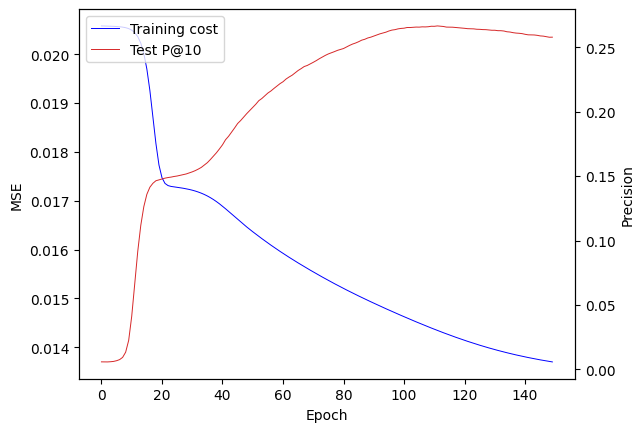

In [10]:
import time, datetime

# For simplicity, we just train the model as we create the model object. And we keep the rating data as a variable
# in the model object.
class MF():
    def __init__(self, ratings, k=50, lrate=.001, nepochs=250,test_tracking=True):
        self.ratings = ratings
        self.test_tracking = test_tracking
        self.train(k, lrate, nepochs)

    # The scoring function.
    def predict(self):
        # Your code here... (hint: can be done in 1 line).
        self.scores_ = (np.dot(self.qi, self.pu.T)).T

    # Initialize the model parameters.
    def init(self, k):
        # Your code here...
        self.qi = np.random.normal(scale=1./k, size=(self.ratings.nitems, k))
        self.pu = np.random.normal(scale=1./k, size=(self.ratings.nusers, k))

    # Train the model (learn the model parameters).
    def train(self, k, lrate, nepochs):
        start_time = time.time()
        self.init(k)
        self.train_errors, self.test_metrics = [], []

        # Training loop.
        for epoch in range(nepochs):
            # Gradient descent steps: model parameters' update.
            # Your code here... (hint: can be done in 3-4 lines).
            self.predict()
            err = self.ratings.train_matrix - self.scores_
            # self.qi = self.qi + lrate*(np.dot(err.T, self.pu) - self.qi)
            # self.pu = self.pu + lrate*(np.dot(err, self.qi) - self.pu)
            self.qi = self.qi + lrate*np.dot(err.T, self.pu)
            self.pu = self.pu + lrate*np.dot(err, self.qi)

            # Produce training trace for inspection.
            train_error = (err**2).mean()
            self.train_errors.append(train_error)
            # We make precision tracking optional as it can be time-consuming.
            if self.test_tracking:
                test_metric = precision(self.scores(), self.ratings.test_matrix, 10)
                self.test_metrics.append(test_metric)
                trace(epoch, start_time, train_error, test_metric, 'P@10')
            else: trace(epoch, start_time, train_error)
        print()

        # If we're not tracking test metrics at least we report it at the end.
        if not self.test_tracking: trace(epoch, start_time, train_error,
                                         precision(self.scores(), self.ratings.test_matrix, 10), 'P@10')

    # Warning: you don't need to use this function -- it's used only for computing precision on test data.
    # Just remove from the prediction scores the matrix cells where there is a training rating: we assume
    # we don't want to recommend stuff the user has already rated, as is most often the case in recommender
    # system applications.
    def scores(self):
        return self.scores_ * (1 - ratings.train_mask)

# Create the model - this will directly trigger training.
np.random.seed(0) # For comparability and debugging (the randomness here is in parameter initialization).
mf = MF(ratings, lrate=.001, nepochs=150)

# Plot the training error and test metric trace.
plot(mf.train_errors, mf.test_metrics)

## 4.&nbsp; Factorización de matrices: modelo deep learning &ndash; opción a) TensorFlow

Reformulación de la factorización de matrices como caso particular "degenerado" de arquitectura neuronal.

### Ejercicio

Completar los huecos marcados con `# Your code here...`.

Observaciones:
* Por la estructura de datos de entrenamiento que maneja TensorFlow, entrenar con toda la matriz de ratings (incluyendo todas las celdas sin dato) es demasiado costoso. Por ello se tomará una muestra pequeña de ejemlos negativos en cada época.
* En el esqueleto que aquí se proporciona, no se genera la traza (curva) de P@10 durante el entrenamiento ya que no encaja fácilmente en el API Keras de TensorFlow.

In [11]:
import tensorflow as tf
from keras import Input
from keras.layers import Embedding, Flatten, Dot,Dense, Reshape
from keras.models import Model
from tqdm.keras import TqdmCallback
import time, datetime, IPython

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 input_10 (InputLayer)       [(None, None)]               0         []                            
                                                                                                  
 embedding_8 (Embedding)     (None, None, 50)             302000    ['input_9[0][0]']             
                                                                                                  
 embedding_9 (Embedding)     (None, None, 50)             185300    ['input_10[0][0]']            
                                                                                            

0epoch [00:00, ?epoch/s]

38/38 [==============================] - 1s 14ms/step
Training model --> Epochs: 151  Training error: 0.032116785645484924  Test P@10: 0.2173675496688742 [0:03:23]                        

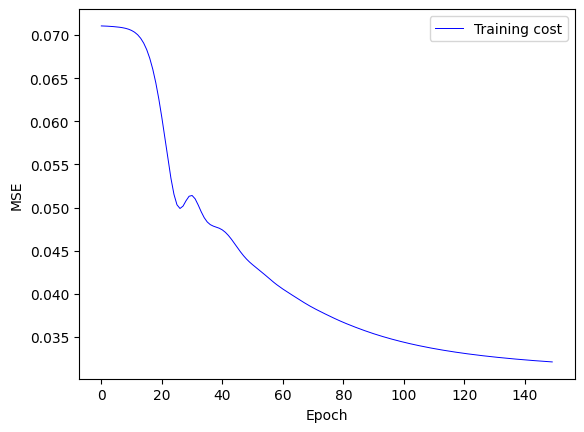

In [12]:
# See the file 'tf-model.png' that was generated with a solution to this exercise - when you run
# your own implementation, you will get your own plot.
def create_model(k=50, lrate=.01, neg=4, nepochs=150):
    # 'users' is an input layer of type tf.int64.
    users = Input(shape=(None,), dtype=tf.int64)
    user_embeddings = Embedding(ratings.nusers, k)(users)
    # user_embeddings = Flatten()(user_embeddings)
    # 'items' is an input layer of type tf.int64.
    items = Input(shape=(None,), dtype=tf.int64)
    item_embeddings = Embedding(ratings.nitems, k)(items)
    # item_embeddings = Flatten()(item_embeddings)
    # TensorFlow has a built-in dot-product layer.
    dot = Dot(axes=1)([user_embeddings, item_embeddings])
    # Now we need a generic model that wraps up the "network", specifying the input and output layers.
    tf_mf = Model(inputs=[users, items], outputs=dot)

    # Compile the model: Adam optimizer is suggested here over SGD.
    opt = tf.keras.optimizers.Adam(learning_rate=lrate)
    tf_mf.compile(loss='mse', optimizer=opt)

    # Show the model topology - a plot will be produced in a file 'tf-model.png'.
    tf_mf.summary()
    tf.keras.utils.plot_model(tf_mf, to_file='tf-model.png', show_shapes=True, dpi=150)

    hist = train_model(tf_mf, neg, nepochs)
    return tf_mf, hist

def train_model(tf_mf, neg, nepochs):
    # We inject 'neg' negative samples for every available rating in the training data
    nneg = neg * ratings.ntrain
    users = np.concatenate((ratings.train_df.u, np.random.randint(ratings.nusers, size=nneg)))
    items = np.concatenate((ratings.train_df.i, np.random.randint(ratings.nitems, size=nneg)))
    rs = ratings.train_matrix[users, items]
    batch_size = ratings.ntrain + nneg # Single batch with all the data at once.

    hist = tf_mf.fit(
        [users, items],
        rs,
        epochs=nepochs,
        batch_size=batch_size,
        callbacks=[TqdmCallback(verbose=0)],
        verbose = 0) # Produces a prettier progress bar.
    return hist

# Create the model - this will directly trigger training.
tf.random.set_seed(0) # For comparability and debugging (the randomness here is in parameter initialization).
start_time = time.time()
tf_mf, hist = create_model(k=50,neg=10,lrate=.01, nepochs=150)

# Plot the training error and report the test metric value (P@10).

plot(hist.history['loss'])

uexplode = np.full((ratings.nitems, ratings.nusers), np.arange(ratings.nusers)).T.flatten()
iexplode = np.full((ratings.nusers, ratings.nitems), np.arange(ratings.nitems)).flatten()
scores = tf_mf.predict([uexplode, iexplode], batch_size=ratings.nusers*100,
                       verbose=1).reshape(ratings.nusers, ratings.nitems)
p = precision(scores*(1-ratings.train_mask), ratings.test_matrix, 10)
trace(hist.params['epochs'], start_time, hist.history['loss'][-1], p, 'P@10')

## 5.&nbsp; Ampliación

### Ejercicio

Explorar variaciones sobre una o varias de las implementaciones anteriores, tales como:
* Diferentes funciones de scoring pérdida: sigmoide / BCE loss, BCE loss with logits.
* Diferentes optimizadores y configuraciones de los mismos (SGD, Adam, etc.).
* Variaciones en los hiperparámetros y configuración del modelo: learning rate, número de factores k, número de épocas, inicialización de parámetros del modelo, etc.
* Muestreo negativo: diferente número de ejemplos negativos.
* Añadir opciones tales como regularización, dropout, etc.
* Variaciones del modelo: términos de bias (usuario/item/global), ponderaciones de datos (p.e. ver modelo sencillo "*confidence weight*" de Hu, Koren & Volinsky), etc.
* Añadir capas ocultas en la implementación sobre framework de deep learning.
* Explorar una formulación *pairwise learning to rank* sobre MF (p.e. BPR).
* Probar otros modelos de factorización de matrices.

Idealmente estas variaciones buscan mejorar la precisión de la recomendación, pero se valorarán intentos interesantes aunque resulten fallidos en ese aspecto.

**RESPUESTA:** A continuación, se realizan las siguientes variaciones en las implementaciones:

#### 1. Se prueban diferentes funciones de scoring pérdida:

    - A. Con BCE y logits
    En este segamento se puede observar que la utilizar la función de pérdida BCE (con logits) se obtuvo una P@10 de 0.18 y un loss de 0.16. Claramente al utilizar esta función se obtuvo un peor performance que MSE.

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, None)]               0         []                            
                                                                                                  
 input_12 (InputLayer)       [(None, None)]               0         []                            
                                                                                                  
 embedding_10 (Embedding)    (None, None, 50)             302000    ['input_11[0][0]']            
                                                                                                  
 embedding_11 (Embedding)    (None, None, 50)             185300    ['input_12[0][0]']            
                                                                                            

0epoch [00:00, ?epoch/s]

38/38 [==============================] - 1s 21ms/step
Training model --> Epochs: 151  Training error: 0.15365521609783173  Test P@10: 0.16137417218543046 [0:03:18]                        

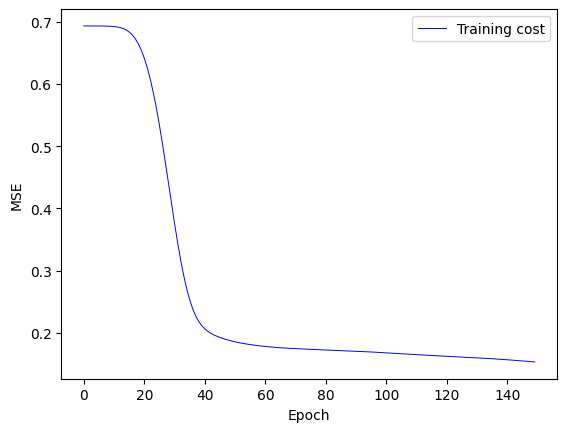

In [13]:
# See the file 'tf-model.png' that was generated with a solution to this exercise - when you run
# your own implementation,    you will get your own plot.
def create_model(k=50, lrate=.01, neg=4, nepochs=150):
    # 'users' is an input layer of type tf.int64.
    users = Input(shape=(None,), dtype=tf.int64)
    user_embeddings = Embedding(ratings.nusers, k)(users)
    # user_embeddings = Flatten()(user_embeddings)
    # 'items' is an input layer of type tf.int64.
    items = Input(shape=(None,), dtype=tf.int64)
    item_embeddings = Embedding(ratings.nitems, k)(items)
    # item_embeddings = Flatten()(item_embeddings)
    # TensorFlow has a built-in dot-product layer.
    dot = Dot(axes=1)([user_embeddings, item_embeddings])
    # Now we need a generic model that wraps up the "network", specifying the input and output layers.
    tf_mf = Model(inputs=[users, items], outputs=dot)

    # En esta sección se varia la función de loss autilizada  <==========================================
    opt = tf.keras.optimizers.Adam(learning_rate=lrate)
    loss= tf.keras.losses.BinaryCrossentropy(from_logits=True)
    tf_mf.compile(loss=loss, optimizer=opt)

    # Show the model topology - a plot will be produced in a file 'tf-model.png'.
    tf_mf.summary()
    tf.keras.utils.plot_model(tf_mf, to_file='tf-model.png', show_shapes=True, dpi=150)

    hist = train_model(tf_mf, neg, nepochs)
    return tf_mf, hist

def train_model(tf_mf, neg, nepochs):
    # We inject 'neg' negative samples for every available rating in the training data
    nneg = neg * ratings.ntrain
    users = np.concatenate((ratings.train_df.u, np.random.randint(ratings.nusers, size=nneg)))
    items = np.concatenate((ratings.train_df.i, np.random.randint(ratings.nitems, size=nneg)))
    rs = ratings.train_matrix[users, items]
    batch_size = ratings.ntrain + nneg # Single batch with all the data at once.

    hist = tf_mf.fit(
        [users, items],
        rs,
        epochs=nepochs,
        batch_size=batch_size,
        callbacks=[TqdmCallback(verbose=0)],
        verbose = 0) # Produces a prettier progress bar.
    return hist

# Create the model - this will directly trigger training.
tf.random.set_seed(0) # For comparability and debugging (the randomness here is in parameter initialization).
start_time = time.time()
tf_mf, hist = create_model(k=50,neg=10,lrate=.01, nepochs=150)

# Plot the training error and report the test metric value (P@10).

plot(hist.history['loss'])

uexplode = np.full((ratings.nitems, ratings.nusers), np.arange(ratings.nusers)).T.flatten()
iexplode = np.full((ratings.nusers, ratings.nitems), np.arange(ratings.nitems)).flatten()
scores = tf_mf.predict([uexplode, iexplode], batch_size=ratings.nusers*100,
                       verbose=1).reshape(ratings.nusers, ratings.nitems)
p = precision(scores*(1-ratings.train_mask), ratings.test_matrix, 10)
trace(hist.params['epochs'], start_time, hist.history['loss'][-1], p, 'P@10')

    - B. Con BCE sin logits
    Se puede apreciar que tuvo un peor performance en comparación al utilizar la función de pérdida BCE (con logits), obteniendo un P@10 de 0.14 y un loss de 0.16. En este sentido, se puede apreciar que puede ser más beneficioso utilizar logits con esta función.

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_13 (InputLayer)       [(None, None)]               0         []                            
                                                                                                  
 input_14 (InputLayer)       [(None, None)]               0         []                            
                                                                                                  
 embedding_12 (Embedding)    (None, None, 50)             302000    ['input_13[0][0]']            
                                                                                                  
 embedding_13 (Embedding)    (None, None, 50)             185300    ['input_14[0][0]']            
                                                                                            

0epoch [00:00, ?epoch/s]

38/38 [==============================] - 1s 13ms/step
Training model --> Epochs: 151  Training error: 0.14607909321784973  Test P@10: 0.14400662251655627 [0:03:26]                        

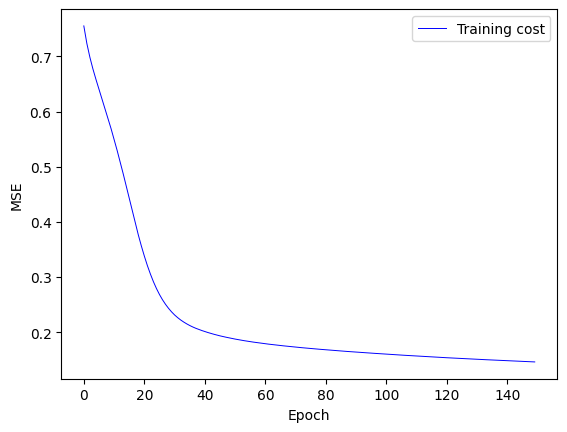

In [14]:
# See the file 'tf-model.png' that was generated with a solution to this exercise - when you run
# your own implementation,    you will get your own plot.
def create_model(k=50, lrate=.01, neg=4, nepochs=150):
    # 'users' is an input layer of type tf.int64.
    users = Input(shape=(None,), dtype=tf.int64)
    user_embeddings = Embedding(ratings.nusers, k)(users)
    # user_embeddings = Flatten()(user_embeddings)
    # 'items' is an input layer of type tf.int64.
    items = Input(shape=(None,), dtype=tf.int64)
    item_embeddings = Embedding(ratings.nitems, k)(items)
    # item_embeddings = Flatten()(item_embeddings)
    # TensorFlow has a built-in dot-product layer.
    dot = Dot(axes=1)([user_embeddings, item_embeddings])
    # Now we need a generic model that wraps up the "network", specifying the input and output layers.
    tf_mf = Model(inputs=[users, items], outputs=dot)

    # En esta sección se varia la función de loss autilizada  <==========================================
    opt = tf.keras.optimizers.Adam(learning_rate=lrate)
    loss= tf.keras.losses.BinaryCrossentropy(from_logits=False)
    tf_mf.compile(loss=loss, optimizer=opt)

    # Show the model topology - a plot will be produced in a file 'tf-model.png'.
    tf_mf.summary()
    tf.keras.utils.plot_model(tf_mf, to_file='tf-model.png', show_shapes=True, dpi=150)

    hist = train_model(tf_mf, neg, nepochs)
    return tf_mf, hist

def train_model(tf_mf, neg, nepochs):
    # We inject 'neg' negative samples for every available rating in the training data
    nneg = neg * ratings.ntrain
    users = np.concatenate((ratings.train_df.u, np.random.randint(ratings.nusers, size=nneg)))
    items = np.concatenate((ratings.train_df.i, np.random.randint(ratings.nitems, size=nneg)))
    rs = ratings.train_matrix[users, items]
    batch_size = ratings.ntrain + nneg # Single batch with all the data at once.

    hist = tf_mf.fit(
        [users, items],
        rs,
        epochs=nepochs,
        batch_size=batch_size,
        callbacks=[TqdmCallback(verbose=0)],
        verbose = 0) # Produces a prettier progress bar.
    return hist

# Create the model - this will directly trigger training.
tf.random.set_seed(0) # For comparability and debugging (the randomness here is in parameter initialization).
start_time = time.time()
tf_mf, hist = create_model(k=50,neg=10,lrate=.01, nepochs=150)

# Plot the training error and report the test metric value (P@10).

plot(hist.history['loss'])

uexplode = np.full((ratings.nitems, ratings.nusers), np.arange(ratings.nusers)).T.flatten()
iexplode = np.full((ratings.nusers, ratings.nitems), np.arange(ratings.nitems)).flatten()
scores = tf_mf.predict([uexplode, iexplode], batch_size=ratings.nusers*100,
                       verbose=1).reshape(ratings.nusers, ratings.nitems)
p = precision(scores*(1-ratings.train_mask), ratings.test_matrix, 10)
trace(hist.params['epochs'], start_time, hist.history['loss'][-1], p, 'P@10')

    - Con BFC (Binary Focal Crossentropy) con logits
    En este modelo vemos que obtuvimos unas métricas comparables al modelo original con MSE, ya que se obtuvo un P@10 de 0.20 y un loss de 0.038, adicionalmente se pudo notar que al utilizar esta función se utiliza más memoria por lo que se bajaron las muestras negativas a 7 (en vez de 8 como en los modelos anteriores), lo cual afecta al modelo ya que se ha visto que al incluir más muestras negativas en los datos se obtiene un mejor rendimiento en el modelo. Además, es importante notar que la curva de loss cae más rápido que con MSE, por lo que podría interesante realizar más pruevas con BFC.

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_15 (InputLayer)       [(None, None)]               0         []                            
                                                                                                  
 input_16 (InputLayer)       [(None, None)]               0         []                            
                                                                                                  
 embedding_14 (Embedding)    (None, None, 50)             302000    ['input_15[0][0]']            
                                                                                                  
 embedding_15 (Embedding)    (None, None, 50)             185300    ['input_16[0][0]']            
                                                                                            

0epoch [00:00, ?epoch/s]

38/38 [==============================] - 1s 14ms/step
Training model --> Epochs: 151  Training error: 0.03475207835435867  Test P@10: 0.20433774834437088 [0:03:26]                        

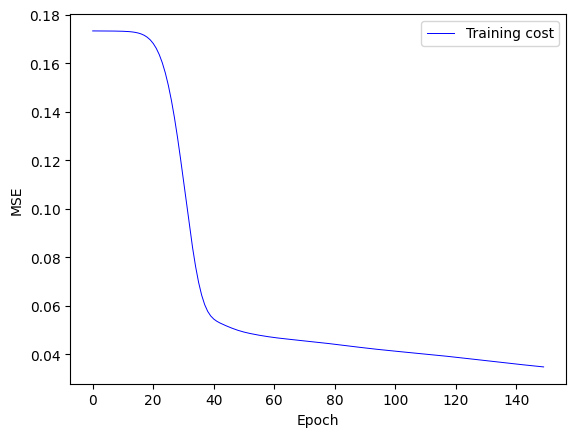

In [15]:
# See the file 'tf-model.png' that was generated with a solution to this exercise - when you run
# your own implementation,    you will get your own plot.
def create_model(k=50, lrate=.01, neg=4, nepochs=150):
    # 'users' is an input layer of type tf.int64.
    users = Input(shape=(None,), dtype=tf.int64)
    user_embeddings = Embedding(ratings.nusers, k)(users)
    # user_embeddings = Flatten()(user_embeddings)
    # 'items' is an input layer of type tf.int64.
    items = Input(shape=(None,), dtype=tf.int64)
    item_embeddings = Embedding(ratings.nitems, k)(items)
    # item_embeddings = Flatten()(item_embeddings)
    # TensorFlow has a built-in dot-product layer.
    dot = Dot(axes=1)([user_embeddings, item_embeddings])
    # Now we need a generic model that wraps up the "network", specifying the input and output layers.

    tf_mf = Model(inputs=[users, items], outputs=dot)

    # En esta sección se varia la función de loss autilizada  <==========================================
    opt = tf.keras.optimizers.Adam(learning_rate=lrate)
    loss= tf.keras.losses.BinaryFocalCrossentropy(from_logits=True)
    tf_mf.compile(loss=loss, optimizer=opt)

    # Show the model topology - a plot will be produced in a file 'tf-model.png'.
    tf_mf.summary()
    tf.keras.utils.plot_model(tf_mf, to_file='tf-model.png', show_shapes=True, dpi=150)

    hist = train_model(tf_mf, neg, nepochs)
    return tf_mf, hist

def train_model(tf_mf, neg, nepochs):
    # We inject 'neg' negative samples for every available rating in the training data
    nneg = neg * ratings.ntrain
    users = np.concatenate((ratings.train_df.u, np.random.randint(ratings.nusers, size=nneg)))
    items = np.concatenate((ratings.train_df.i, np.random.randint(ratings.nitems, size=nneg)))
    rs = ratings.train_matrix[users, items]
    batch_size = ratings.ntrain + nneg # Single batch with all the data at once.

    hist = tf_mf.fit(
        [users, items],
        rs,
        epochs=nepochs,
        batch_size=batch_size,
        callbacks=[TqdmCallback(verbose=0)],
        verbose = 0) # Produces a prettier progress bar.
    return hist

# Create the model - this will directly trigger training.
tf.random.set_seed(0) # For comparability and debugging (the randomness here is in parameter initialization).
start_time = time.time()
tf_mf, hist = create_model(k=50,neg=10,lrate=.01, nepochs=150)

# Plot the training error and report the test metric value (P@10).

plot(hist.history['loss'])

uexplode = np.full((ratings.nitems, ratings.nusers), np.arange(ratings.nusers)).T.flatten()
iexplode = np.full((ratings.nusers, ratings.nitems), np.arange(ratings.nitems)).flatten()
scores = tf_mf.predict([uexplode, iexplode], batch_size=ratings.nusers*100,
                       verbose=1).reshape(ratings.nusers, ratings.nitems)
p = precision(scores*(1-ratings.train_mask), ratings.test_matrix, 10)
trace(hist.params['epochs'], start_time, hist.history['loss'][-1], p, 'P@10')

####  2. Añadir capas ocultas en la implementación sobre framework de deep learning.

    - A. A continuación, añadimos dos capas densas de 10 neuronas después de cada Embedding. Se puede apreciar, que al añadir estas capas el loss cae mucho más rápido que en el modelo original, sin emabargo, no se ha obtenido un mejor P@10. En este sentido, se puede ver que disminuir que añadir más capas densas no aporta a mejorar los resultados del modelo

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_17 (InputLayer)       [(None, None)]               0         []                            
                                                                                                  
 input_18 (InputLayer)       [(None, None)]               0         []                            
                                                                                                  
 embedding_16 (Embedding)    (None, None, 50)             302000    ['input_17[0][0]']            
                                                                                                  
 embedding_17 (Embedding)    (None, None, 50)             185300    ['input_18[0][0]']            
                                                                                            

0epoch [00:00, ?epoch/s]

38/38 [==============================] - 1s 13ms/step
Training model --> Epochs: 151  Training error: 0.045574091374874115  Test P@10: 0.16125827814569538 [0:03:11]                        

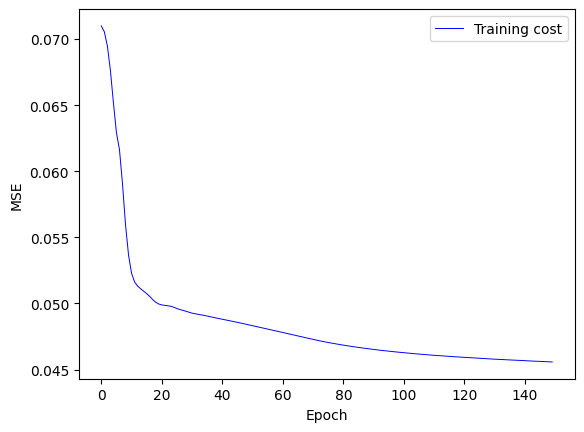

In [16]:
# See the file 'tf-model.png' that was generated with a solution to this exercise - when you run
# your own implementation, you will get your own plot.
def create_model(k=50, lrate=.01, neg=4, nepochs=150):
    # 'users' is an input layer of type tf.int64.
    users = Input(shape=(None,), dtype=tf.int64)
    user_embeddings = Embedding(ratings.nusers, k)(users)
    # user_embeddings = Flatten()(user_embeddings)
    # 'items' is an input layer of type tf.int64.
    items = Input(shape=(None,), dtype=tf.int64)
    item_embeddings = Embedding(ratings.nitems, k)(items)
    # item_embeddings = Flatten()(item_embeddings)
    # TensorFlow has a built-in dot-product layer.

    hidden_layer1_usr = Dense(10, activation='relu')(user_embeddings)
    hidden_layer1_itm = Dense(10, activation='relu')(item_embeddings)
    hidden_layer2_usr = Dense(10, activation='relu')(hidden_layer1_usr)
    hidden_layer2_itm = Dense(10, activation='relu')(hidden_layer1_itm)

    dot = Dot(axes=1)([hidden_layer2_usr, hidden_layer2_itm])
    # Now we need a generic model that wraps up the "network", specifying the input and output layers.

    tf_mf = Model(inputs=[users, items], outputs=dot)

    # Compile the model: Adam optimizer is suggested here over SGD.
    opt = tf.keras.optimizers.Adam(learning_rate=lrate)
    tf_mf.compile(loss='mse', optimizer=opt)

    # Show the model topology - a plot will be produced in a file 'tf-model.png'.
    tf_mf.summary()
    tf.keras.utils.plot_model(tf_mf, to_file='tf-model.png', show_shapes=True, dpi=150)

    hist = train_model(tf_mf, neg, nepochs)
    return tf_mf, hist

def train_model(tf_mf, neg, nepochs):
    # We inject 'neg' negative samples for every available rating in the training data
    nneg = neg * ratings.ntrain
    users = np.concatenate((ratings.train_df.u, np.random.randint(ratings.nusers, size=nneg)))
    items = np.concatenate((ratings.train_df.i, np.random.randint(ratings.nitems, size=nneg)))
    rs = ratings.train_matrix[users, items]
    batch_size = ratings.ntrain + nneg # Single batch with all the data at once.

    hist = tf_mf.fit(
        [users, items],
        rs,
        epochs=nepochs,
        batch_size=batch_size,
        callbacks=[TqdmCallback(verbose=0)],
        verbose = 0) # Produces a prettier progress bar.
    return hist

# Create the model - this will directly trigger training.
tf.random.set_seed(0) # For comparability and debugging (the randomness here is in parameter initialization).
start_time = time.time()
tf_mf, hist = create_model(k=50,neg=10,lrate=.01, nepochs=150)

# Plot the training error and report the test metric value (P@10).

plot(hist.history['loss'])

uexplode = np.full((ratings.nitems, ratings.nusers), np.arange(ratings.nusers)).T.flatten()
iexplode = np.full((ratings.nusers, ratings.nitems), np.arange(ratings.nitems)).flatten()
scores = tf_mf.predict([uexplode, iexplode], batch_size=ratings.nusers*100,
                       verbose=1).reshape(ratings.nusers, ratings.nitems)
p = precision(scores*(1-ratings.train_mask), ratings.test_matrix, 10)
trace(hist.params['epochs'], start_time, hist.history['loss'][-1], p, 'P@10')

#### 3. Variaciones en los hiperparámetros y configuración del modelo: learning rate, número de factores k, número de épocas, inicialización de parámetros del modelo, etc.

    - Variación de Learning Rate (lr = 0.1)
    Se puede notar que al aumentar el learning rate a 0.1 se obtienen resultados muy simialares que con el learning rate en 0.01, llegando a un 0.206 de P@10 y a un loss de 0.03.


Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_19 (InputLayer)       [(None, None)]               0         []                            
                                                                                                  
 input_20 (InputLayer)       [(None, None)]               0         []                            
                                                                                                  
 embedding_18 (Embedding)    (None, None, 50)             302000    ['input_19[0][0]']            
                                                                                                  
 embedding_19 (Embedding)    (None, None, 50)             185300    ['input_20[0][0]']            
                                                                                            

0epoch [00:00, ?epoch/s]

38/38 [==============================] - 1s 12ms/step
Training model --> Epochs: 151  Training error: 0.030525900423526764  Test P@10: 0.20640728476821193 [0:03:03]                        

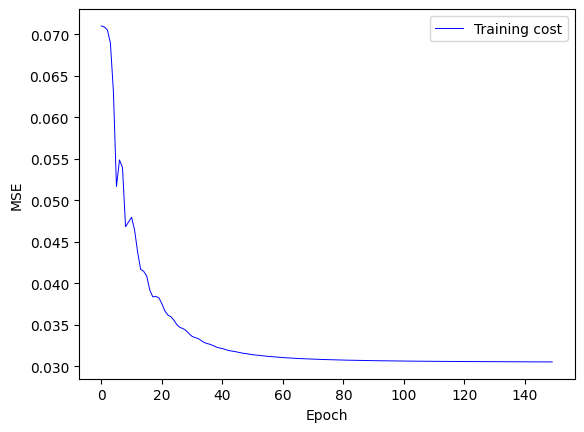

In [17]:
# See the file 'tf-model.png' that was generated with a solution to this exercise - when you run
# your own implementation, you will get your own plot.
def create_model(k=50, lrate=.01, neg=4, nepochs=150):
    # 'users' is an input layer of type tf.int64.
    users = Input(shape=(None,), dtype=tf.int64)
    user_embeddings = Embedding(ratings.nusers, k)(users)
    # user_embeddings = Flatten()(user_embeddings)
    # 'items' is an input layer of type tf.int64.
    items = Input(shape=(None,), dtype=tf.int64)
    item_embeddings = Embedding(ratings.nitems, k)(items)
    # item_embeddings = Flatten()(item_embeddings)
    # TensorFlow has a built-in dot-product layer.
    dot = Dot(axes=1)([user_embeddings, item_embeddings])
    # Now we need a generic model that wraps up the "network", specifying the input and output layers.
    tf_mf = Model(inputs=[users, items], outputs=dot)

    # Compile the model: Adam optimizer is suggested here over SGD.
    opt = tf.keras.optimizers.Adam(learning_rate=lrate)
    tf_mf.compile(loss='mse', optimizer=opt)

    # Show the model topology - a plot will be produced in a file 'tf-model.png'.
    tf_mf.summary()
    tf.keras.utils.plot_model(tf_mf, to_file='tf-model.png', show_shapes=True, dpi=150)

    hist = train_model(tf_mf, neg, nepochs)
    return tf_mf, hist

def train_model(tf_mf, neg, nepochs):
    # We inject 'neg' negative samples for every available rating in the training data
    nneg = neg * ratings.ntrain
    users = np.concatenate((ratings.train_df.u, np.random.randint(ratings.nusers, size=nneg)))
    items = np.concatenate((ratings.train_df.i, np.random.randint(ratings.nitems, size=nneg)))
    rs = ratings.train_matrix[users, items]
    batch_size = ratings.ntrain + nneg # Single batch with all the data at once.

    hist = tf_mf.fit(
        [users, items],
        rs,
        epochs=nepochs,
        batch_size=batch_size,
        callbacks=[TqdmCallback(verbose=0)],
        verbose = 0) # Produces a prettier progress bar.
    return hist

# Create the model - this will directly trigger training.
tf.random.set_seed(0) # For comparability and debugging (the randomness here is in parameter initialization).
start_time = time.time()
tf_mf, hist = create_model(k=50,neg=10,lrate=.1, nepochs=150)

# Plot the training error and report the test metric value (P@10).

plot(hist.history['loss'])

uexplode = np.full((ratings.nitems, ratings.nusers), np.arange(ratings.nusers)).T.flatten()
iexplode = np.full((ratings.nusers, ratings.nitems), np.arange(ratings.nitems)).flatten()
scores = tf_mf.predict([uexplode, iexplode], batch_size=ratings.nusers*100,
                       verbose=1).reshape(ratings.nusers, ratings.nitems)
p = precision(scores*(1-ratings.train_mask), ratings.test_matrix, 10)
trace(hist.params['epochs'], start_time, hist.history['loss'][-1], p, 'P@10')

    - Variación de Learning Rate (lr = 0.001)
    Por otro lado la disminuir el learning rate (dando pasos más pequeños) vemos que el performance del modelo cae de manera significativa ya que ahora solo hemos alcanzado una presición P@10 de 0.15 y un loss por encima del modelo original.

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_21 (InputLayer)       [(None, None)]               0         []                            
                                                                                                  
 input_22 (InputLayer)       [(None, None)]               0         []                            
                                                                                                  
 embedding_20 (Embedding)    (None, None, 50)             302000    ['input_21[0][0]']            
                                                                                                  
 embedding_21 (Embedding)    (None, None, 50)             185300    ['input_22[0][0]']            
                                                                                           

0epoch [00:00, ?epoch/s]

38/38 [==============================] - 1s 13ms/step
Training model --> Epochs: 151  Training error: 0.04864304140210152  Test P@10: 0.15834437086092715 [0:03:02]                        

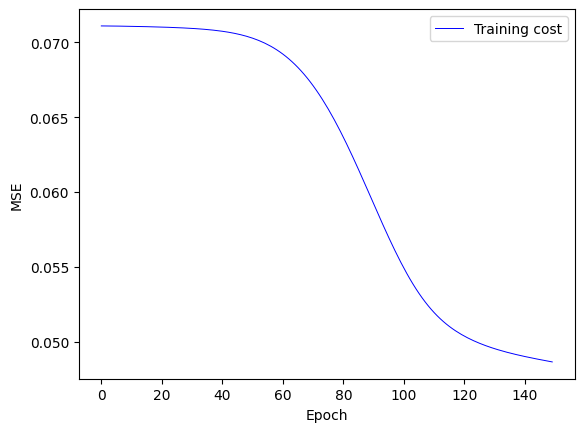

In [18]:
# Create the model - this will directly trigger training.
tf.random.set_seed(0) # For comparability and debugging (the randomness here is in parameter initialization).
start_time = time.time()
tf_mf, hist = create_model(k=50,neg=10,lrate=.001, nepochs=150)

# Plot the training error and report the test metric value (P@10).

plot(hist.history['loss'])

uexplode = np.full((ratings.nitems, ratings.nusers), np.arange(ratings.nusers)).T.flatten()
iexplode = np.full((ratings.nusers, ratings.nitems), np.arange(ratings.nitems)).flatten()
scores = tf_mf.predict([uexplode, iexplode], batch_size=ratings.nusers*100,
                       verbose=1).reshape(ratings.nusers, ratings.nitems)
p = precision(scores*(1-ratings.train_mask), ratings.test_matrix, 10)
trace(hist.params['epochs'], start_time, hist.history['loss'][-1], p, 'P@10')

    - Variación de k (k = 60)
    A continución, se ha aumentado el tamaño de k a 60 (debido a limites de memoria no fue posible a umentar más la k). Se puede apreciar un performance similar al del modelo original (a penas más bajo que el modelo original) lo cual es lo esperado ya que k no crece demasiado.

Model: "model_15"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_31 (InputLayer)       [(None, None)]               0         []                            
                                                                                                  
 input_32 (InputLayer)       [(None, None)]               0         []                            
                                                                                                  
 embedding_30 (Embedding)    (None, None, 60)             362400    ['input_31[0][0]']            
                                                                                                  
 embedding_31 (Embedding)    (None, None, 60)             222360    ['input_32[0][0]']            
                                                                                           

0epoch [00:00, ?epoch/s]

38/38 [==============================] - 1s 14ms/step
Training model --> Epochs: 151  Training error: 0.030426226556301117  Test P@10: 0.20971854304635762 [0:03:28]                        

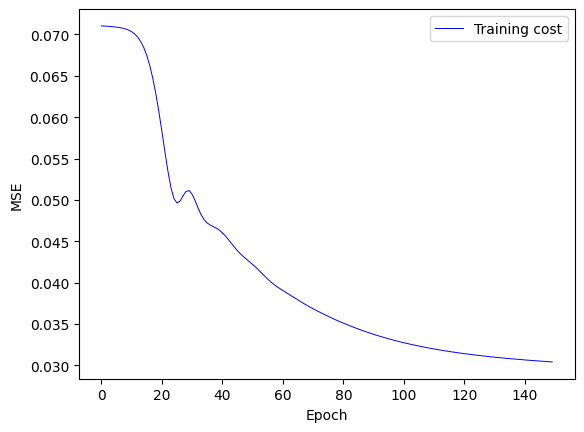

In [23]:
# Create the model - this will directly trigger training.
tf.random.set_seed(0) # For comparability and debugging (the randomness here is in parameter initialization).
start_time = time.time()
tf_mf, hist = create_model(k=60,neg=10,lrate=.01, nepochs=150)

# Plot the training error and report the test metric value (P@10).

plot(hist.history['loss'])

uexplode = np.full((ratings.nitems, ratings.nusers), np.arange(ratings.nusers)).T.flatten()
iexplode = np.full((ratings.nusers, ratings.nitems), np.arange(ratings.nitems)).flatten()
scores = tf_mf.predict([uexplode, iexplode], batch_size=ratings.nusers*100,
                       verbose=1).reshape(ratings.nusers, ratings.nitems)
p = precision(scores*(1-ratings.train_mask), ratings.test_matrix, 10)
trace(hist.params['epochs'], start_time, hist.history['loss'][-1], p, 'P@10')

    - Variación de k (k = 20)
    Ahora hemos disminuido el tamaño de k a 20, mejorando en la presición P@10 y empeorando minimamente en el loss. En este caso, se ha alcanzado casi un 0.24 de P@10 y un 0.038 de loss.

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_33 (InputLayer)       [(None, None)]               0         []                            
                                                                                                  
 input_34 (InputLayer)       [(None, None)]               0         []                            
                                                                                                  
 embedding_32 (Embedding)    (None, None, 20)             120800    ['input_33[0][0]']            
                                                                                                  
 embedding_33 (Embedding)    (None, None, 20)             74120     ['input_34[0][0]']            
                                                                                           

0epoch [00:00, ?epoch/s]

38/38 [==============================] - 1s 12ms/step
Training model --> Epochs: 151  Training error: 0.03791603073477745  Test P@10: 0.23970198675496687 [0:03:17]                        

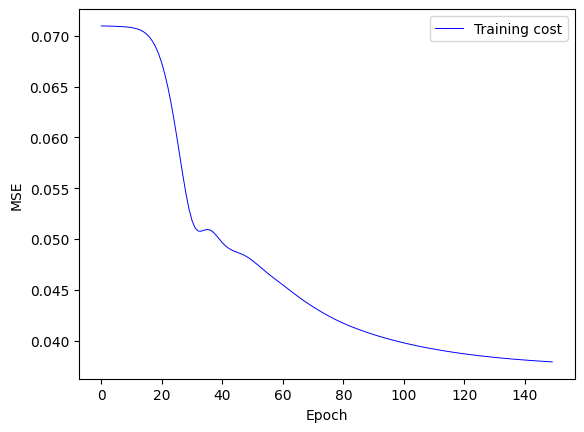

In [24]:
# Create the model - this will directly trigger training.
tf.random.set_seed(0) # For comparability and debugging (the randomness here is in parameter initialization).
start_time = time.time()
tf_mf, hist = create_model(k=20,neg=10,lrate=.01, nepochs=150)

# Plot the training error and report the test metric value (P@10).

plot(hist.history['loss'])

uexplode = np.full((ratings.nitems, ratings.nusers), np.arange(ratings.nusers)).T.flatten()
iexplode = np.full((ratings.nusers, ratings.nitems), np.arange(ratings.nitems)).flatten()
scores = tf_mf.predict([uexplode, iexplode], batch_size=ratings.nusers*100,
                       verbose=1).reshape(ratings.nusers, ratings.nitems)
p = precision(scores*(1-ratings.train_mask), ratings.test_matrix, 10)
trace(hist.params['epochs'], start_time, hist.history['loss'][-1], p, 'P@10')